In [1]:
import module_loader
import pandas as pd
from bookirds.curves import *
from bookirds.dual import Dual

### Pricing curve is assumed accurate

This curve only has the four instruments 2Y, 5Y, 10Y, 30Y, as per the text.

In [2]:
nodes = {
    datetime(2022, 1, 1): Dual(1, {"v0": 1}),
    datetime(2024, 1, 1): Dual(1, {"v1": 1}),
    datetime(2027, 1, 1): Dual(1, {"v2": 1}),
    datetime(2032, 1, 1): Dual(1, {"v3": 1}),
    datetime(2052, 1, 1): Dual(1, {"v4": 1})
}
swaps = {
    Swap(datetime(2022, 1, 1), 12*2, 12, 12): 1.635,
    Swap(datetime(2022, 1, 1), 12*5, 12, 12): 1.885,
    Swap(datetime(2022, 1, 1), 12*10, 12, 12): 1.930,
    Swap(datetime(2022, 1, 1), 12*30, 12, 12): 1.980,
}
s_cv = SolvedCurve(
    nodes=nodes,
    swaps=list(swaps.keys()),
    obj_rates=list(swaps.values()),
    interpolation="log_linear",
    algorithm="levenberg_marquardt"
)
print(s_cv.iterate())

tolerance reached (levenberg_marquardt) after 12 iterations, func: 3.692989489074287e-18


### Equivalent portfolios

Suppose we construct three portfolios, each with either;

  - A single 5Y5Y swap,
  - A 5Y swap and a 10Y swap,
  - A 5s10s swap spread and a 10Y swap,

These portfolios are **equivalent** since their cashflows are identical.


In [3]:
portfolio1 = Portfolio([
    Swap(datetime(2027,1,1), 12*5, 12, 12, fixed_rate=1.9797, notional=-100e6)
])
portfolio2 = Portfolio([
    Swap(datetime(2022,1,1), 12*5, 12, 12, fixed_rate=1.9797, notional=100e6),
    Swap(datetime(2022,1,1), 12*10, 12, 12, fixed_rate=1.9797, notional=-100e6)
])
portfolio3 = Portfolio([
    Swap(datetime(2022,1,1), 12*5, 12, 12, fixed_rate=1.9797, notional=100e6),
    Swap(datetime(2022,1,1), 12*10, 12, 12, fixed_rate=1.9797, notional=-50e6),
    Swap(datetime(2022,1,1), 12*10, 12, 12, fixed_rate=1.9797, notional=-50e6)
])

df = pd.DataFrame({
    "pf1": portfolio1.risk(s_cv)[:,0],
    "pf2": portfolio2.risk(s_cv)[:,0],
    "pf3": portfolio3.risk(s_cv)[:,0],
}, index=["2y", "5y", "10y", "30y"])
df.style.format("{:,.0f}")

fwd tolerance reached (gauss_newton) after 2 iterations, func: 4.199397490950246e-26
bck tolerance reached (gauss_newton) after 2 iterations, func: 1.7514684248169515e-27
fwd tolerance reached (gauss_newton) after 2 iterations, func: 2.65090889350345e-25
bck tolerance reached (gauss_newton) after 2 iterations, func: 3.010377030794561e-25
fwd tolerance reached (gauss_newton) after 2 iterations, func: 3.768634570235589e-25
bck tolerance reached (gauss_newton) after 2 iterations, func: 3.589816073278156e-25
fwd tolerance reached (gauss_newton) after 3 iterations, func: 8.504640393858521e-26
bck tolerance reached (gauss_newton) after 3 iterations, func: 8.504152286173416e-26


,pf1,pf2,pf3
2y,23,23,23
5y,"47,433","47,433","47,433"
10y,"-90,529","-90,529","-90,529"
30y,0,0,0


### Parametrised instruments

Next we use the prices and the insruments as parametrised in the text.

In [4]:
df = pd.DataFrame({
    "2Y": [1, 0, 0, 0, -1, -1, -1, 0, 0, 0, -1, 0],
    "5Y": [0, 1, 0, 0, 1, 0, 0, -1, -1, 0, 2, -1],
    "10Y": [0, 0, 1, 0, 0, 1, 0, 1, 0, -1, -1, 2],
    "30Y": [0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, -1],
    "margin": [0.4, 0.5, 0.5, 0.6, 0.25, 0.45, 0.85, 0.25, 0.7, 0.55, 0.5, 0.6],
}, index=["2Y", "5Y", "10Y", "30Y", "2s5s", "2s10s", "2s30s", "5s10s", "5s30s", "10s30s", "2s5s10s", "5s10s30s"])
df.style

,2Y,5Y,10Y,30Y,margin
2Y,1,0,0,0,0.400000
5Y,0,1,0,0,0.500000
10Y,0,0,1,0,0.500000
30Y,0,0,0,1,0.600000
2s5s,-1,1,0,0,0.250000
2s10s,-1,0,1,0,0.450000
2s30s,-1,0,0,1,0.850000
5s10s,0,-1,1,0,0.250000
5s30s,0,-1,0,1,0.700000
10s30s,0,0,-1,1,0.550000


In [5]:
c = df["margin"].to_numpy()[:, np.newaxis]
A = df[["2Y", "5Y", "10Y", "30Y"]].to_numpy().T
S = portfolio1.risk(s_cv)
ret = portfolio1.model_margin(c, A, portfolio1.risk(s_cv))

In [6]:
df["x"], x = ret[1], ret[1][:, np.newaxis]
df.style.format("{:,.1f}")

,2Y,5Y,10Y,30Y,margin,x
2Y,1.0,0.0,0.0,0.0,0.4,-0.0
5Y,0.0,1.0,0.0,0.0,0.5,-0.0
10Y,0.0,0.0,1.0,0.0,0.5,"-43,073.1"
30Y,0.0,0.0,0.0,1.0,0.6,0.0
2s5s,-1.0,1.0,0.0,0.0,0.2,-0.0
2s10s,-1.0,0.0,1.0,0.0,0.5,-22.5
2s30s,-1.0,0.0,0.0,1.0,0.8,-0.0
5s10s,0.0,-1.0,1.0,0.0,0.2,"-47,433.4"
5s30s,0.0,-1.0,0.0,1.0,0.7,-0.0
10s30s,0.0,0.0,-1.0,1.0,0.6,-0.0


The solution to this linear program is the above 'x' column and the calculated margin for these instruments is, below, which equates to a margin, from mid, of 0.78bps on the delta of the underlying 5Y5Y IRS.

In [7]:
ret[0]

33405.03110638657

### Volume

To account for the fact that our model is volume agnostic we will assume an additional hedge cost of:

$$ \frac{2}{3000} * \sqrt{x_i} * x_i $$

In [8]:
df["basic margin"] = df["margin"] * np.abs(df["x"])
df["volume add on"] = 2/3000 * np.abs(df["x"])**1.5
df.style.format("{:,.1f}")

,2Y,5Y,10Y,30Y,margin,x,basic margin,volume add on
2Y,1.0,0.0,0.0,0.0,0.4,-0.0,0.0,0.0
5Y,0.0,1.0,0.0,0.0,0.5,-0.0,0.0,0.0
10Y,0.0,0.0,1.0,0.0,0.5,"-43,073.1","21,536.5","5,959.6"
30Y,0.0,0.0,0.0,1.0,0.6,0.0,0.0,0.0
2s5s,-1.0,1.0,0.0,0.0,0.2,-0.0,0.0,0.0
2s10s,-1.0,0.0,1.0,0.0,0.5,-22.5,10.1,0.1
2s30s,-1.0,0.0,0.0,1.0,0.8,-0.0,0.0,0.0
5s10s,0.0,-1.0,1.0,0.0,0.2,"-47,433.4","11,858.4","6,887.1"
5s30s,0.0,-1.0,0.0,1.0,0.7,-0.0,0.0,0.0
10s30s,0.0,0.0,-1.0,1.0,0.6,-0.0,0.0,0.0


### Correlation of identified market hedges

The hedges that our model has identified will be assessed to see if they are correlated and if we need to charge extra.

In [9]:
historical_rates = pd.DataFrame({
    "2Y": [1.199, 1.228, 1.210, 1.215, 1.203, 1.159, 1.175, 1.188, 1.159, 1.100],
    "5Y": [1.663, 1.696, 1.665, 1.680, 1.677, 1.657, 1.673, 1.676, 1.653, 1.600],
    "10Y": [1.928, 1.945, 1.934, 1.93, 1.934, 1.931, 1.958, 1.972, 1.932, 1.900],
    "30Y": [2.201, 2.217, 2.228, 2.239, 2.226, 2.235, 2.242, 2.236, 2.22, 2.200],
})
historical_chgs = historical_rates.diff(-1)*100
historical_chgs.style.format("{:,.1f}")
Q = historical_chgs.cov().to_numpy()
Q

array([[8.66      , 7.3775    , 5.13625   , 2.185     ],
       [7.3775    , 7.3075    , 4.73      , 2.1575    ],
       [5.13625   , 4.73      , 4.89111111, 1.76236111],
       [2.185     , 2.1575    , 1.76236111, 1.86111111]])

In [10]:
Q_model = np.matmul(np.matmul(A.T, Q), A)
df2 = pd.DataFrame(Q_model, index=df.index, columns=df.index)
df2.style.format("{:,.2f}")

,2Y,5Y,10Y,30Y,2s5s,2s10s,2s30s,5s10s,5s30s,10s30s,2s5s10s,5s10s30s
2Y,8.66,7.38,5.14,2.19,-1.28,-3.52,-6.47,-2.24,-5.19,-2.95,0.96,0.71
5Y,7.38,7.31,4.73,2.16,-0.07,-2.65,-5.22,-2.58,-5.15,-2.57,2.51,-0.00
10Y,5.14,4.73,4.89,1.76,-0.41,-0.25,-3.37,0.16,-2.97,-3.13,-0.57,3.29
30Y,2.19,2.16,1.76,1.86,-0.03,-0.42,-0.32,-0.40,-0.30,0.10,0.37,-0.49
2s5s,-1.28,-0.07,-0.41,-0.03,1.21,0.88,1.25,-0.34,0.04,0.38,1.55,-0.71
2s10s,-3.52,-2.65,-0.25,-0.42,0.88,3.28,3.10,2.40,2.22,-0.18,-1.53,2.58
2s30s,-6.47,-5.22,-3.37,-0.32,1.25,3.10,6.15,1.85,4.90,3.05,-0.59,-1.20
5s10s,-2.24,-2.58,0.16,-0.40,-0.34,2.40,1.85,2.74,2.18,-0.56,-3.07,3.29
5s30s,-5.19,-5.15,-2.97,-0.30,0.04,2.22,4.90,2.18,4.85,2.67,-2.14,-0.49
10s30s,-2.95,-2.57,-3.13,0.10,0.38,-0.18,3.05,-0.56,2.67,3.23,0.93,-3.78


#### CoVaR Multiplier
The covar multiplier for the trade is:

In [11]:
covar = np.matmul(np.matmul(x.T, Q_model), x)[0][0] ** 0.5
covar

np.float64(126091.63847801813)

In [12]:
covar_zerocorr = np.matmul(np.matmul(x.T, np.diag(np.diagonal(Q_model))), x)[0][0] ** 0.5
covar_zerocorr

np.float64(123434.62650447342)

The covar multiplier for the trade assuming completely uncorrelated instruments is:

The difference is quite small. We can observe from the covariance matrix that 10Y and 5s10s has low correlation.

### Liquidity Assessment

Assume the bund future represents our market, we calculate the intrinsic bid-ask width from different order books representing different conditions.

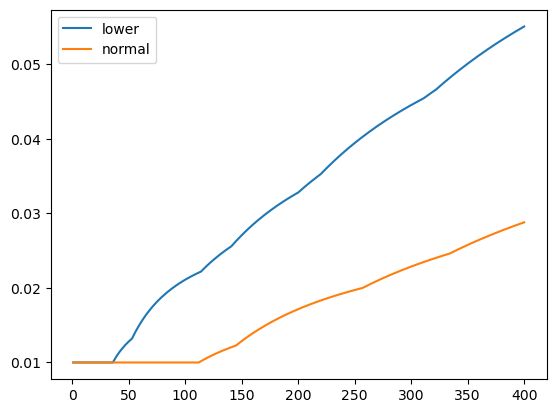

In [13]:
b = np.array([169.70, 169.69, 169.68, 169.67, 169.66, 169.65])
a = np.array([169.71, 169.72, 169.73, 169.74, 169.75, 169.76])
w1 = np.array([36, 78, 86, 111, 121, 189])
v1 = np.array([53, 88, 79, 102, 198, 213])
w2 = np.array([112, 145, 165, 156, 198, 256])
v2 = np.array([145, 189, 199, 212, 215, 278])

import matplotlib.pyplot as plt
from bookirds.mid_market import single_sided_ida

z = np.linspace(1, 400, 400)

fig, ax = plt.subplots(1,1)
ax.plot(z, [single_sided_ida(a, v1, x) - single_sided_ida(b, w1, x) for x in z], label="lower")
ax.plot(z, [single_sided_ida(a, v2, x) - single_sided_ida(b, w2, x) for x in z], label="normal")
ax.legend()
plt.show()

### Total Margin

Basic margin:

In [14]:
f"Ccy: {df['basic margin'].sum():,.0f}"

'Ccy: 33,405'

Volume add-on adjusted for liquidity:

In [15]:
f"Ccy: {df['volume add on'].sum() * 2:,.0f}"

'Ccy: 25,694'

Correlation add-on adjusted for liquidity:

In [16]:
f"Ccy: {(covar - covar_zerocorr) * 2:,.0f}"

'Ccy: 5,314'

Total Margin:

In [17]:
tm = df["basic margin"].sum() + df["volume add on"].sum() * 2 + (covar - covar_zerocorr) * 2
f"Ccy: {tm:,.0f}"

'Ccy: 64,413'

# Alternative Example

Specify the risk and mid-market NPV of the requested trade.

In [18]:
portfolio = Portfolio([
    Swap(datetime(2023,1,1), 12*4, 12, 12, notional=-100e6, fixed_rate=1.5),
    Swap(datetime(2027,5,21), 12*9, 12, 12, notional=45e6, fixed_rate=2.0),
    Swap(datetime(2028,9,16), 12*14, 12, 12, notional=21e6, fixed_rate=1.9)
])
portfolio.risk(s_cv)

array([[  9985.19023984],
       [-73154.59648459],
       [ 28139.35620729],
       [ 53482.80872486]])

In [19]:
f"Ccy: {portfolio.npv(s_cv).real:,.0f}"

'Ccy: -1,473,959'

Get the current market-maker risk inventory

In [20]:
S_inv = np.array([[1000, 35000, -10000, -35000]]).transpose()
x_inv = portfolio.model_margin(c, A, S_inv)[1][:, np.newaxis]

In [21]:
ret = portfolio.model_margin(c, A, portfolio.risk(s_cv))
df = pd.DataFrame({
    "2Y": [1, 0, 0, 0, -1, -1, -1, 0, 0, 0, -1, 0],
    "5Y": [0, 1, 0, 0, 1, 0, 0, -1, -1, 0, 2, -1],
    "10Y": [0, 0, 1, 0, 0, 1, 0, 1, 0, -1, -1, 2],
    "30Y": [0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, -1],
    "margin": [0.4, 0.5, 0.5, 0.6, 0.25, 0.45, 0.85, 0.25, 0.7, 0.55, 0.5, 0.6],
}, index=["2Y", "5Y", "10Y", "30Y", "2s5s", "2s10s", "2s30s", "5s10s", "5s30s", "10s30s", "2s5s10s", "5s10s30s"])
df["x"], x = ret[1], ret[1][:, np.newaxis]
df["x_inv"] = x_inv[:, 0]
df["basic margin"] = df["margin"] * np.abs(df["x"])
df["volume add on"] = 2/3000 * (np.abs((x_inv+x))**1.5 - np.abs(x_inv)**1.5)
df.style.format("{:,.1f}")

,2Y,5Y,10Y,30Y,margin,x,x_inv,basic margin,volume add on
2Y,1.0,0.0,0.0,0.0,0.4,-0.0,-0.0,0.0,0.0
5Y,0.0,1.0,0.0,0.0,0.5,-0.0,-0.0,0.0,0.0
10Y,0.0,0.0,1.0,0.0,0.5,-0.0,-0.0,0.0,0.0
30Y,0.0,0.0,0.0,1.0,0.6,"18,452.8","-9,000.0","11,071.7",43.5
2s5s,-1.0,1.0,0.0,0.0,0.2,-0.0,-0.0,0.0,0.0
2s10s,-1.0,0.0,1.0,0.0,0.5,0.0,-0.0,0.0,0.0
2s30s,-1.0,0.0,0.0,1.0,0.8,-0.0,"-1,000.0",0.0,0.0
5s10s,0.0,-1.0,1.0,0.0,0.2,"18,154.2","-10,000.0","4,538.5",-175.8
5s30s,0.0,-1.0,0.0,1.0,0.7,"35,030.1","-25,000.0","24,521.0","-1,965.6"
10s30s,0.0,0.0,-1.0,1.0,0.6,-0.0,-0.0,0.0,0.0


In [22]:
covar = np.matmul(np.matmul(x.T, Q_model), x)[0][0] ** 0.5
covar

np.float64(112059.07001730968)

In [23]:
covar_zerocorr = np.matmul(np.matmul(x.T, np.diag(np.diagonal(Q_model))), x)[0][0] ** 0.5
covar_zerocorr

np.float64(89180.55205669193)

The total we charge for this swap package is

In [24]:
auto_margin = df["basic margin"].sum() + df["volume add on"].sum() + (covar - covar_zerocorr) * 0.15
f"Ccy: {auto_margin:,.0f}"

'Ccy: 47,123'

The price show to the customer is (negative is customer pays cash)

In [25]:
f"Ccy: {(portfolio.npv(s_cv) - auto_margin).real:,.0f}"

'Ccy: -1,521,082'

This does not include an off-the-run charge which is a major component of risk in this package.